### Sentiment analysis on reviews data
Kei Sato

ML310B - Advanced Machine Learning

March 25, 2019


We will be using reviews data to develop a sentiment analyzer, such that given a document, the model can predict if the review is positive (sentiment = 1) or negative (sentiment = 0)


In [1]:
# Load the data...
import pandas as pd
from nltk.tokenize import word_tokenize

data = pd.read_csv('resources/Reviews.csv')

print("Number of positive and negative reviews", '\n', data["sentiment"].value_counts())
data.head()

Number of positive and negative reviews 
 1    25000
0    25000
Name: sentiment, dtype: int64


,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


#### Initial Text Processing
The reviews corpus has 50,000 reviews and is evenly split between positive and negative reviews, so that it contains 25,000 positive and 25,000 negative reviews.  Before doing any more data exploration, we process the text using standard techniques.  Much of this code was taken from the Lesson 8 HW assignment.

The first step is apply some basic text processing, it was done in the following order.
1.  Remove proper nouns:  This was done by using the NLTK position tagging functionality to identify proper nouns.
2.  Expand contractions
3.  Convert all text to lowercase
4.  Remove `<br />` characters, this was because the `<br />` HTML tag was present in many reviews.  This part of cleaning the text was specific to this corpus.
5.  Remove symbols and punctuation
6.  Remove stop words.  For this application, I also removed the words "movie" and "film" because they were occured very often throughout positive and negative reviews.

After cleaning the text, lemmatization is applied.  I did try to apply stemming to the dataset, but that produced too many non words and so it has been omitted from the text processing steps.

In [70]:
# Taken Lesson 8 HW assignment
from nltk.corpus import stopwords
from nltk import tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import json

# setting global variables
with open('resources/contractions.json', 'r') as f:
    contractions = json.load(f)
contractions_keys = contractions.keys()

replace_re_by_space = re.compile('[/(){}\[\]\|@,;]')
delete_re_symbols = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))
stop_words.add("movie")
stop_words.add("film")

count = 0    

def combine_tokened_words(tokened_words):
    length_of_string=len(tokened_words)
    text_new=""
    for w in tokened_words:
        if w!=tokened_words[length_of_string-1]:
             text_new=text_new+w+" " # when w is not the last word so separate by whitespace
        else:
            text_new=text_new+w
    return text_new

# converts to lowercase and removes <br />, punctuation, stop words, and numbers
def text_processing(text):
    global count
    count+=1
    if (count % 500 == 0):
        print("COUNT:", count)

    tagged_sentence = tag.pos_tag(text.split())
    text = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    test = list(map(lambda word: contractions[word] if word in contractions_keys else word, text))
    text = (' '.join(text))
    
    text = text.lower()
    text = text.replace("<br />", '')
    text = re.sub(replace_re_by_space.pattern, ' ', text)
    text = re.sub(delete_re_symbols.pattern, '', text)
    token_word = word_tokenize(text)

    # filtered_sentence contain all words that are not in stopwords dictionary    
    filtered_sentence = [w for w in token_word if not w in stop_words]
    return filtered_sentence

# Lemmatizes words
def text_lemmatization(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    text = list(map(lambda word: wordnet_lemmatizer.lemmatize(word), text))
    return text

# test_data = data[:10000].copy(deep=True)
test_data = data.copy(deep=True)
test_data["review"] = test_data["review"].apply(lambda text:
                                                combine_tokened_words(
                                                    text_lemmatization(
                                                        text_processing(text)
                                                    )
                                                  )
                                               )
print("done processing data")

COUNT: 500
COUNT: 1000
COUNT: 1500
COUNT: 2000
COUNT: 2500
COUNT: 3000
COUNT: 3500
COUNT: 4000
COUNT: 4500
COUNT: 5000
COUNT: 5500
COUNT: 6000
COUNT: 6500
COUNT: 7000
COUNT: 7500
COUNT: 8000
COUNT: 8500
COUNT: 9000
COUNT: 9500
COUNT: 10000
COUNT: 10500
COUNT: 11000
COUNT: 11500
COUNT: 12000
COUNT: 12500
COUNT: 13000
COUNT: 13500
COUNT: 14000
COUNT: 14500
COUNT: 15000
COUNT: 15500
COUNT: 16000
COUNT: 16500
COUNT: 17000
COUNT: 17500
COUNT: 18000
COUNT: 18500
COUNT: 19000
COUNT: 19500
COUNT: 20000
COUNT: 20500
COUNT: 21000
COUNT: 21500
COUNT: 22000
COUNT: 22500
COUNT: 23000
COUNT: 23500
COUNT: 24000
COUNT: 24500
COUNT: 25000
COUNT: 25500
COUNT: 26000
COUNT: 26500
COUNT: 27000
COUNT: 27500
COUNT: 28000
COUNT: 28500
COUNT: 29000
COUNT: 29500
COUNT: 30000
COUNT: 30500
COUNT: 31000
COUNT: 31500
COUNT: 32000
COUNT: 32500
COUNT: 33000
COUNT: 33500
COUNT: 34000
COUNT: 34500
COUNT: 35000
COUNT: 35500
COUNT: 36000
COUNT: 36500
COUNT: 37000
COUNT: 37500
COUNT: 38000
COUNT: 38500
COUNT: 39000
COUNT:

#### Data exploration
Below is some initial data exploration.  We can see that the average length of positive and negative reviews is roughtly the same.  The ten most frequently occuring words are also very similar across between the sets of positive and negative reviews.  I also outputted the ten least commonly occuring words, in part for my own curiosity and to verify that the ten least commonly occuring words were still complete words.

In [71]:
import numpy as np
from collections import Counter 
from functools import reduce
from operator import itemgetter
import heapq

# Get average length of reviews
def get_avg_length_review(data, sentiment):
    print("get_avg_length_review")
    relevant_reviews = data.loc[data["sentiment"] == sentiment]["review"]
    avg_review_length = list(map(lambda review: len(review.split()), relevant_reviews))
    return int(np.mean(avg_review_length))
print("Average word count of negative reviews:", get_avg_length_review(test_data, 0))
print("Average word count of positive reviews:", get_avg_length_review(test_data, 1))

# Get 10 most and least frequently occuring words, verify that real words are coming through
def get_most_least_common_words(data, sentiment):
    print("get_most_least_common_words")
    relevant_reviews = data.loc[data["sentiment"] == sentiment]["review"]
    all_relevant_reviews = reduce(lambda accum, curr: accum + curr, relevant_reviews)
    counted_words = Counter(all_relevant_reviews.split())
    most_common = counted_words.most_common(10)
    least_common = heapq.nsmallest(10, counted_words.items(), key=itemgetter(1))
    return most_common, least_common

negative_reviews = get_most_least_common_words(test_data, 0)
positive_reviews = get_most_least_common_words(test_data, 1)

print('\n')
print("10 most common words in negative reviews:", negative_reviews[0])
print("10 least common words in negative reviews:", negative_reviews[1])
print('\n')
print("10 most common words in positive reviews:", positive_reviews[0])
print("10 least common words in positive reviews:", positive_reviews[1])


get_avg_length_review
Average word count of negative reviews: 100
get_avg_length_review
Average word count of positive reviews: 99
get_most_least_common_words
get_most_least_common_words


10 most common words in negative reviews: [('one', 23823), ('like', 21496), ('even', 14625), ('character', 13744), ('good', 13448), ('would', 13361), ('time', 13139), ('get', 12928), ('bad', 12683), ('make', 12312)]
10 least common words in negative reviews: [('callinternet', 1), ('garbageanyone', 1), ('60ship', 1), ('twitter', 1), ('fauxinfant', 1), ('seachange', 1), ('lessoften', 1), ('yearsmany', 1), ('imaginationchallenged', 1), ('flopperoo', 1)]


10 most common words in positive reviews: [('one', 25089), ('like', 16898), ('time', 14278), ('character', 13460), ('good', 13447), ('story', 12856), ('see', 11564), ('great', 11314), ('make', 10805), ('get', 10792)]
10 least common words in positive reviews: [('ralphtheallpurposeanimal', 1), ('filmedhumanity', 1), ('nextarguebly', 1), ('breakem', 1), 

#### More data processing and running the model

The data transformed by using TFIDIF then fed into a Logistic Regression classifier.  I am using a test train split of 30% and 70%.  The model is run with data that is processed with different ngram lengths and minimum document frequency values.  I am also using the SKlearn cross validation module to test different parameters for the Logistic Regression model itself.

I chose the Logistic Regression model because this is a supervised learning problem with binary labels.  I also tried running an SVM model but it took too long to run on my machine with the complete dataset.  Using a decision tree was also considered but the dataset seemed too sparse to use that model.

For this example, the minimium document frequency is varied while the maximum document frequency remains constant at 0.9.  The model is tested against the following min_df values: 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05.  I chose to vary the minimum value instead of the maximum value because I assumed that would reduce the instances of non words in the dataset as well as reducing noise.  However, I am interested in the effect that changing the max_df would have as well.  The n-grams value is also varied, using values (1, 1), (1, 2), and (1, 3).  I did not go beyond (1, 3) because using a smaller portion of data, I was not seeing a significant difference in results after categorizing words using n-grams greater than 3.  After processing this data, if the transformed TFIDIF matrix had more features than instances, I would not run the model.  This was done because when running the model on such a matrix (with a subset of data) there was performance degredation, which was likely due to the Logistic Regression classifier not handling datasets with mroe features than rows well.  


In [72]:
from sklearn import metrics
import matplotlib.pyplot as plt
    
def get_incorrect_predictions(data, y_true, y_pred):
    predicted_pos = 0
    predicted_neg = 0
    correct_predictions = 0
    incorrect_predictions = pd.DataFrame({'review': [], 'sentiment': []})
    for i in range(0, len(y_true)):
        if y_true[i] == y_pred[i]:
            correct_predictions+=1
        else:
            incorrect_predictions.loc[len(incorrect_predictions)] = [data[i], y_pred[i]]
            if y_pred[i] == 1:
                predicted_pos+=1
            else:
                predicted_neg+=1
    print("Predicted POSITIVE, actually NEGATIVE", round(float(predicted_pos)/float(len(y_true)), 3))
    print("Predicted NEGATIVE, actually POSITIVE", round(float(predicted_neg)/float(len(y_true)), 3))
    print('\n')
    return incorrect_predictions

def graph_accuracy(accuracies, min_dfs):
    for accuracy in accuracies:
        plt.plot(min_dfs, list(accuracy["scores"]), label=accuracy["label"])
        plt.xlabel('Minimum document frequency')
        plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc="best", borderaxespad=0, title="n gram")
    plt.show()



ngram range (1, 1)
min_df value 0.0001
done vectorizing
fitting the model on dataset with these dimensions (35000, 26535)
Best params: {'C': 0.9, 'max_iter': 150, 'solver': 'sag'}
Accuracy: 0.883
AUC Score: 0.883
Predicted POSITIVE, actually NEGATIVE 0.064
Predicted NEGATIVE, actually POSITIVE 0.053


For incorrectly predicted reviews:
get_most_least_common_words
Most and least common of predicted negative reviews: ([('one', 703), ('like', 620), ('good', 438), ('get', 409), ('would', 388), ('much', 384), ('time', 381), ('make', 379), ('really', 367), ('even', 353)], [('hater', 1), ('mdixon', 1), ('thermodynamics', 1), ('perished', 1), ('ecology', 1), ('verify', 1), ('burnzero', 1), ('madethe', 1), ('bullying', 1), ('filmso', 1)])
get_most_least_common_words
Most and least common of predicted positive reviews: ([('one', 842), ('like', 646), ('good', 477), ('story', 474), ('time', 443), ('see', 434), ('get', 422), ('character', 419), ('would', 412), ('really', 396)], [('tribal', 1), ('c

done vectorizing
fitting the model on dataset with these dimensions (35000, 12526)
Best params: {'C': 0.9, 'max_iter': 200, 'solver': 'sag'}
Accuracy: 0.887
AUC Score: 0.887
Predicted POSITIVE, actually NEGATIVE 0.062
Predicted NEGATIVE, actually POSITIVE 0.052


For incorrectly predicted reviews:
get_most_least_common_words
Most and least common of predicted negative reviews: ([('one', 713), ('like', 628), ('good', 434), ('much', 400), ('get', 397), ('would', 388), ('time', 378), ('make', 373), ('really', 349), ('even', 345)], [('hater', 1), ('mdixon', 1), ('thermodynamics', 1), ('perished', 1), ('ecology', 1), ('textbook', 1), ('verify', 1), ('burnzero', 1), ('columbine', 1), ('madethe', 1)])
get_most_least_common_words
Most and least common of predicted positive reviews: ([('one', 815), ('like', 629), ('good', 471), ('story', 446), ('time', 437), ('get', 414), ('see', 401), ('would', 400), ('character', 397), ('really', 383)], [('galloping', 1), ('carriage', 1), ('copiesbr', 1), ('l

done vectorizing
fitting the model on dataset with these dimensions (35000, 1545)
Best params: {'C': 0.9, 'max_iter': 150, 'solver': 'saga'}
Accuracy: 0.869
AUC Score: 0.869
Predicted POSITIVE, actually NEGATIVE 0.07
Predicted NEGATIVE, actually POSITIVE 0.061


For incorrectly predicted reviews:
get_most_least_common_words
Most and least common of predicted negative reviews: ([('one', 841), ('like', 685), ('good', 479), ('get', 462), ('time', 445), ('would', 437), ('much', 423), ('character', 409), ('even', 407), ('make', 403)], [('mdixon', 1), ('thermodynamics', 1), ('ecology', 1), ('verify', 1), ('burnzero', 1), ('columbine', 1), ('pipe', 1), ('madethe', 1), ('filmso', 1), ('messedreason', 1)])
get_most_least_common_words
Most and least common of predicted positive reviews: ([('one', 944), ('like', 735), ('good', 533), ('story', 520), ('character', 483), ('would', 478), ('time', 470), ('get', 456), ('see', 423), ('really', 419)], [('tribal', 1), ('cheapest', 1), ('unscariest', 1), (

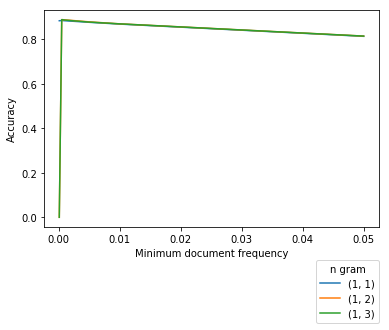

In [73]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# returns the accuracy
def print_metrics(x_test, y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred), 3)
    print("Accuracy:", acc)        
    print("AUC Score:", round(roc_auc_score(y_test, y_pred), 3))

    incorrect_pred = get_incorrect_predictions(list(x_test), list(y_test), y_pred)
    print("For incorrectly predicted reviews:")
    print("Most and least common of predicted negative reviews:", get_most_least_common_words(incorrect_pred, 0))
    print("Most and least common of predicted positive reviews:", get_most_least_common_words(incorrect_pred, 1))
    return acc

def run_model_cv(data):   
    x_train, x_test, y_train, y_test = train_test_split(
        data["review"],
        data["sentiment"],
        test_size=0.3,
        random_state=42
    )
    
    ngram_range = [
        (1, 1),
        (1, 2),
        (1, 3)
    ]
    
    min_df_range = [
        0.0001,
        0.0005,
        0.001,
        0.005,
        0.01,
        0.05
    ]
    
    accuracy_by_ngram = []
    for ngram_param in ngram_range:
        accuracy_by_min_df = []
        for min_df_param in min_df_range:
            print("\nngram range", ngram_param)
            print("min_df value", min_df_param)
            vectorizer = TfidfVectorizer(max_df=0.9, min_df=min_df_param, ngram_range=ngram_param).fit(x_train)
            _x_train = vectorizer.transform(x_train)
            
            # If there are more columns than rows, exit           
            if (_x_train.shape[1] < _x_train.shape[0]):
                _x_test = vectorizer.transform(x_test)
                print("done vectorizing")

                cv_clf = GridSearchCV(
                            LogisticRegression(),
                            [
                                {
                                    "solver": ["sag", "saga"],
                                    "C": [0.1, 0.5, 0.9],
                                    "max_iter": [150, 200, 250]
                                }
                            ],
                            cv=5,
                            refit=True
                        )
                print("fitting the model on dataset with these dimensions", _x_train.shape)
                cv_clf.fit(_x_train, y_train)
                print("Best params:", cv_clf.best_params_)

                y_pred = cv_clf.predict(_x_test)
                accuracy = print_metrics(x_test, y_test, y_pred)
                accuracy_by_min_df.append(accuracy)
            else:
                accuracy_by_min_df.append(0)
                print("Too many features, exiting", _x_train.shape)
        accuracy_by_ngram.append({
          "scores": accuracy_by_min_df,
          "label": ngram_param
        })
    print("TRYING TO PLOT")
    print(accuracy_by_ngram)
    print(min_df_range)
    if (len(accuracy_by_ngram) != 0):
        graph_accuracy(accuracy_by_ngram, min_df_range)

run_model_cv(test_data)


The resulting graph displays the minimum document frequency against the accuracy, coded by the n-gram value. 

